In [1]:
# Import required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix
pd.set_option("future.no_silent_downcasting", True)

In [2]:
# Read the dataset
dataset = pd.read_excel('esg-dataset.xlsx')

In [3]:
# Preview the dataset
dataset.head()

,Company,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Level,Controversy Score,ESG_Loan Approval
0,1,A,A,A,A,A,A,A,D,D,Moderate Controversy Level,2.0,High
1,2,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
2,3,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
3,4,B,B,A,A,A,C,A,A,A,None Controversy Level,NaN,High
4,5,B,B,D,A,A,A,A,A,C,Low Controversy Level,1.0,High


In [4]:
# Check the column names
dataset.columns

Index(['Company', 'EGroup1', 'EGroup2', 'EGroup3', 'EGroup4', 'Ggroup',
       'SGroup1', 'SGroup2', 'SGroup3', 'SGroup4', 'Controversy Level',
       'Controversy Score', 'ESG_Loan Approval'],
      dtype='object')

In [5]:
## Selecting the features and target variable
# Controversy Level and Controversy Score reflect the same infomation (highly correlated). So, we can drop one of them.
interested_features = ['EGroup1',
                       'EGroup2',
                       'EGroup3',
                       'EGroup4',
                       'Ggroup',
                       'SGroup1',
                       'SGroup2',
                       'SGroup3',
                       'SGroup4',
                       'Controversy Score']
target_var = 'ESG_Loan Approval'

## Exploratory Data Analysis

In [6]:
dataset_copy = dataset.copy()

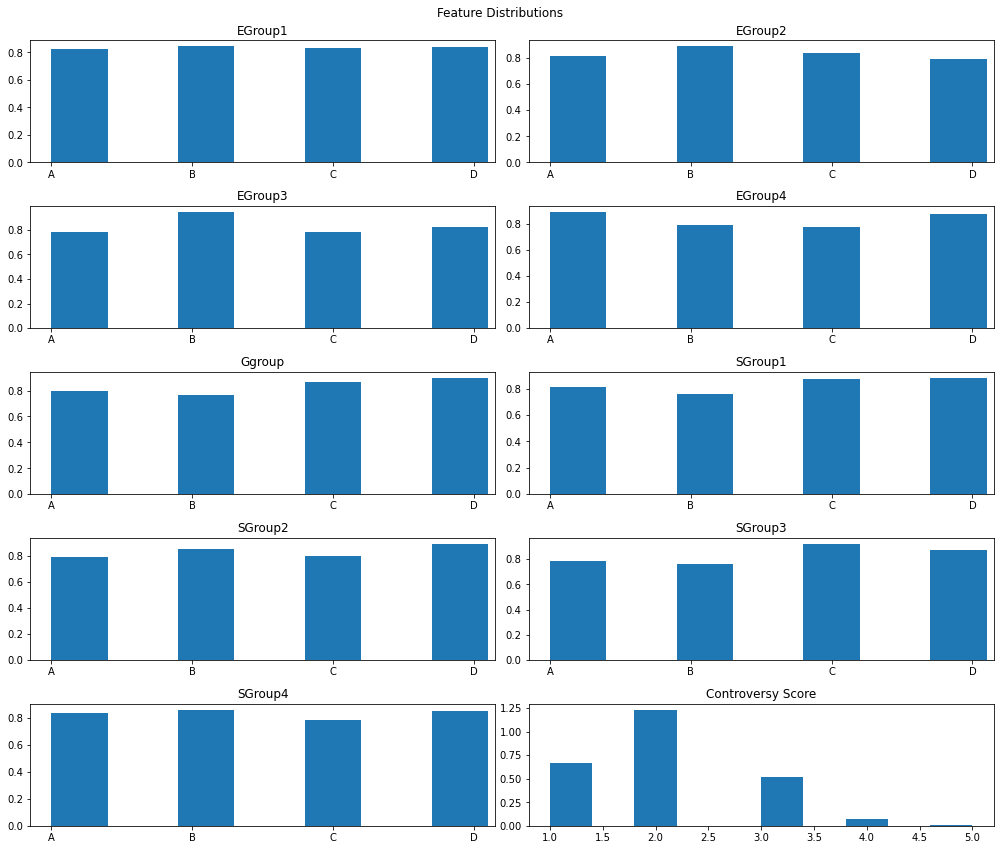

In [7]:
# Feature Distributions
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    ax = plt.subplot(5, 2, i+1)
    ax.hist(dataset_copy[feature].sort_values(), density=True, width = 0.4)
    ax.set_title(feature)
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

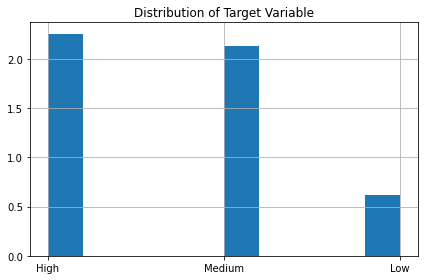

In [8]:
plt.figure()
dataset["ESG_Loan Approval"].hist(density = True)
plt.title("Distribution of Target Variable")
plt.tight_layout()
plt.show()

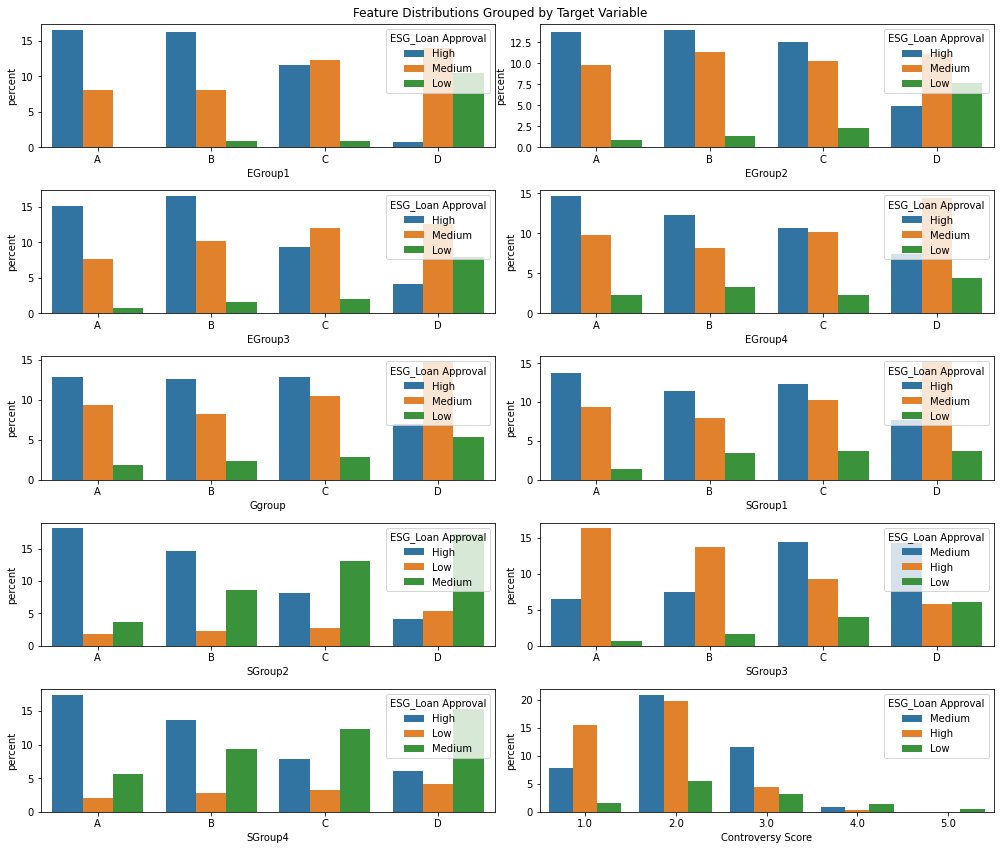

In [9]:
# Distribution of features grouping by target variable
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    plt.subplot(5, 2, i+1)
    dataset_copy = dataset_copy.sort_values(feature)
    sns.countplot(x=feature, data=dataset_copy, hue=target_var, stat = "percent")
plt.suptitle('Feature Distributions Grouped by Target Variable')
plt.tight_layout()
plt.show()

In [10]:
# transform str to int for correlation analysis
mapping = {"A": int(4), "B": int(3), "C": int(2), "D": int(1)}
for feature in interested_features:
    dataset_copy[feature] = dataset_copy[feature].replace(mapping)
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
dataset_copy["ESG_Loan Approval"]=dataset_copy["ESG_Loan Approval"].replace(target_map)

In [11]:
# exclude missing values for now
dataset_copy = dataset_copy.dropna()
# drop out the Contraversy Level column
dataset_copy = dataset_copy.drop(["Controversy Level"], axis=1)

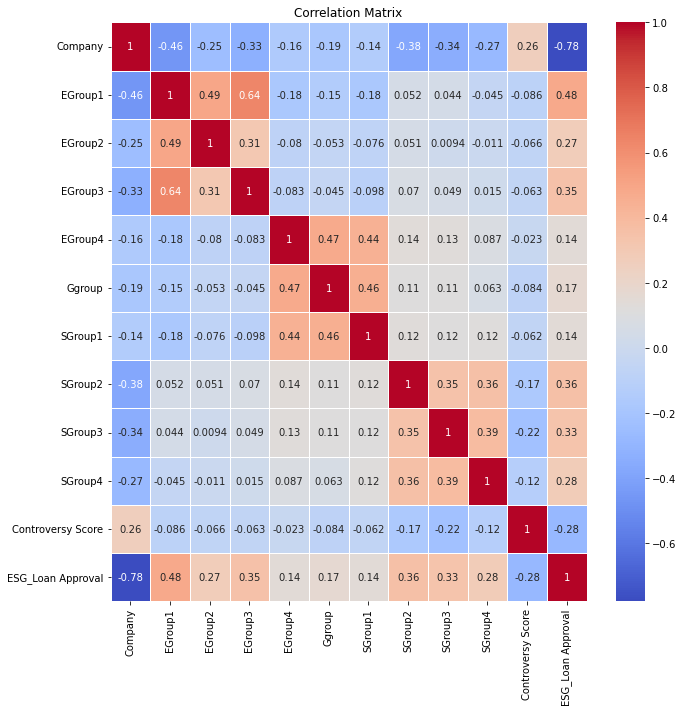

In [12]:
# Kenall Rank Correlation Matrix
corr = dataset_copy.corr(method='kendall')
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Missing Value Detection and Filling

In [13]:
features = dataset[interested_features]
target = dataset[target_var]

In [14]:
# Numebr of sissing value in features
features.isnull().sum()

EGroup1               0
EGroup2               0
EGroup3               0
EGroup4               0
Ggroup                0
SGroup1               0
SGroup2               0
SGroup3               0
SGroup4               0
Controversy Score    27
dtype: int64

In [15]:
# Fill the controversy Score with the mode
mode = features["Controversy Score"].mode()[0]
features.loc[:,"Controversy Score"] = features["Controversy Score"].replace(np.nan, mode)

In [16]:
# Check the missing values again
features.isnull().sum()

EGroup1              0
EGroup2              0
EGroup3              0
EGroup4              0
Ggroup               0
SGroup1              0
SGroup2              0
SGroup3              0
SGroup4              0
Controversy Score    0
dtype: int64

## Data Transformation

In [17]:
# Encode the categorical variables using one-hot encoding
cat_featrues = ['EGroup1',
                'EGroup2',
                'EGroup3',
                'EGroup4',
                'Ggroup',
                'SGroup1',
                'SGroup2',
                'SGroup3',
                'SGroup4']
features = pd.get_dummies(features, columns=cat_featrues, drop_first=False, dtype = int)

In [18]:
# Transform the target variable from categorical to numerical
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
target = target.replace(target_map).astype(int)

## Modelling

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

In [20]:
# Baseline model: Logistic Regression
logis_classifier = LogisticRegression()
param_grid = {
    'C': [2, 1, 0.5, 0.1, 0.05],
    'class_weight': [None, 'balanced'],
    'penalty': ['none', 'l2']
}
grid_search = GridSearchCV(estimator=logis_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_xgb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 20 candidates, totalling 160 fits
{'C': 1, 'class_weight': None, 'penalty': 'l2'}


In [21]:
pred_train_logist = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_logist)
prec_train = precision_score(y_train,pred_train_logist, average='macro')
recall_train = recall_score(y_train,pred_train_logist, average='macro')
f1_train = f1_score(y_train,pred_train_logist, average='macro')

pred_test_logist = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_logist)
prec_test = precision_score(y_test,pred_test_logist, average='macro')
recall_test = recall_score(y_test,pred_test_logist, average='macro')
f1_test = f1_score(y_test,pred_test_logist, average='macro')

In [22]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_test))
print("Train Precision: %.4f" %(prec_test))
print("Train recall: %.4f" %(recall_test))
print("Train f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.8088
Train Precision: 0.8048
Train recall: 0.7332
Train f1-score: 0.7575
**********Test Phase**********
Train Acc: 0.7674
Train Precision: 0.6991
Train recall: 0.6661
Train f1-score: 0.6696


In [23]:
# Create a random forest regressor
rf_classifier = RandomForestClassifier()
# grid search for hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'max_features' : ["auto", "sqrt", "log2"]
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_rf_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 192 candidates, totalling 1536 fits
{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 50}


In [24]:
pred_train_rf = best_rf_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_rf)
prec_train = precision_score(y_train,pred_train_rf, average='macro')
recall_train = recall_score(y_train,pred_train_rf, average='macro')
f1_train = f1_score(y_train,pred_train_rf, average='macro')

pred_test_rf = best_rf_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_rf)
prec_test = precision_score(y_test,pred_test_rf, average='macro')
recall_test = recall_score(y_test,pred_test_rf, average='macro')
f1_test = f1_score(y_test,pred_test_rf, average='macro')

In [25]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_test))
print("Train Precision: %.4f" %(prec_test))
print("Train recall: %.4f" %(recall_test))
print("Train f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.8863
Train Precision: 0.9190
Train recall: 0.8026
Train f1-score: 0.8377
**********Test Phase**********
Train Acc: 0.7674
Train Precision: 0.7579
Train recall: 0.6929
Train f1-score: 0.7098


In [26]:
xgb_classifier = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'subsample': [1, 0.95, 0.75, 0.5],
    'lambda': [0.5, 0.2, 0.1],
    'alpha': [10, 5, 2, 1],
    'eta': [0.05, 0.1, 0.3]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_xgb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 1296 candidates, totalling 10368 fits
{'alpha': 1, 'eta': 0.1, 'lambda': 0.5, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}


In [27]:
pred_train_xgbm = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_xgbm)
prec_train = precision_score(y_train,pred_train_xgbm, average='macro')
recall_train = recall_score(y_train,pred_train_xgbm, average='macro')
f1_train = f1_score(y_train,pred_train_xgbm, average='macro')

pred_test_xgbm = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_xgbm)
prec_test = precision_score(y_test,pred_test_xgbm, average='macro')
recall_test = recall_score(y_test,pred_test_xgbm, average='macro')
f1_test = f1_score(y_test,pred_test_xgbm, average='macro')

In [28]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_test))
print("Train Precision: %.4f" %(prec_test))
print("Train recall: %.4f" %(recall_test))
print("Train f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.8450
Train Precision: 0.8772
Train recall: 0.7500
Train f1-score: 0.7836
**********Test Phase**********
Train Acc: 0.7442
Train Precision: 0.7222
Train recall: 0.6494
Train f1-score: 0.6574


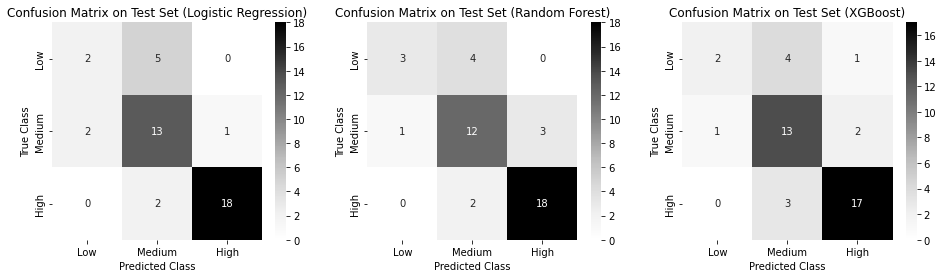

In [29]:
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}

plt.subplots(figsize=(16, 4))
ax1 = plt.subplot(1, 3, 1)
confMat=confusion_matrix(y_test, pred_test_logist)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax1=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax1.set_title('Confusion Matrix on Test Set (Logistic Regression)', fontsize=12)
ax1.set_xlabel('Predicted Class', fontsize=10)
ax1.set_ylabel('True Class', fontsize=10)

ax2 = plt.subplot(1, 3, 2)
confMat=confusion_matrix(y_test, pred_test_rf)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax2=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax2.set_title('Confusion Matrix on Test Set (Random Forest)', fontsize=12)
ax2.set_xlabel('Predicted Class', fontsize=10)
ax2.set_ylabel('True Class', fontsize=10)

ax3 = plt.subplot(1, 3, 3)
confMat=confusion_matrix(y_test, pred_test_xgbm)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax3=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax3.set_title('Confusion Matrix on Test Set (XGBoost)', fontsize=12)
ax3.set_xlabel('Predicted Class', fontsize=10)
ax3.set_ylabel('True Class', fontsize=10)

plt.show()